# Nettoyage

Dans cette partie, nous allons vous présenter comment nous avons identifiées, quantifiées et traitées les données manquantes et aberrantes. De plus nous vous présenterons comment nous avons identifiées, quantifiées et traitées les lignes dupliquées.

In [1]:
import mdls.transpose as tr  # Importation du code professionnel dédié à ce projet
import pandas as pd  # Yeah Pandas !
# import numpy as np et matplotlib.pyplot as plt
%pylab  
# permet d'afficher les graphiques à l'intérieur du notebook jupyter
%matplotlib inline 
from sklearn.experimental import enable_iterative_imputer  #  IterativeImputer as an attribute of the impute module
from sklearn import impute  # Multivariate feature imputation
from sklearn.linear_model import LinearRegression
import sqlite3  # utilisation un fichier comme une base de données
import numba  # utilisation de numpy avec un gpu local
import seaborn as sns
import scipy

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.float_format', None)  # Précise le format des floats (scientifiques …)
pd.set_option('compute.use_numba', True)  # Pour faire du calcul scientifique numpy à l'aide du gpu avec pandas
pd.set_option('display.precision', 2)  # Indique le nombre de chiffres après la virgule affichés dans le cadre

Nous codons nos constantes pour les utiliser dans notre notebook :

1. Les noms de fichiers pour l'analyse univariée est le fichier ne contenant que les données pour l'analyses.

3. le nom de fichier du report est le nom du report fait avec Pandas-profiling.

4. le nom de fichier original est le fichier que nous avons télécharger depuis l'internet.

5. Le seuil de filtrage de valeurs nulles par colonne est fixé à 80%

In [3]:
NAME_FILE_SCORE_UNIVARIATE_ANALYSIS = 'Score_for_univariate_analysis.csv'
NAME_FILE_GRADE_UNIVARIATE_ANALYSIS = 'Grade_for_univariate_analysis.csv'
NAME_FILE_BOTH_UNIVARIATE_ANALYSIS = 'Both_for_univariate_analysis.csv'
REPORT_FILE_NAME = "OpenFoodFactReport.html"
NAME_FILE_ORIGINAL = 'fr.openfoodfacts.org.products.csv'
NAME_FILE_PICKLE = 'fr.openfoodfacts.org.products.dat'
LEVEL_OF_NULL_FILTER = 80  # In pourcents

Pour réctifier nos données, nous avons définie des seuils maximum pour les valeurs de colonnes. Ce sont des colonnes de nombres qui ont suffisamment de valeurs non-nulles pour participer à l'analyse.

In [4]:
SEUILS_DE_VALEURS: dict = {
    'energy_100g': 3900,
    'fat_100g': 100,
    'saturated-fat_100g': 92.6,
    'trans-fat_100g': 37,
    'cholesterol_100g': 3.1,
    'carbohydrates_100g': 99.8,
    'sugars_100g': 99.6,
    'fiber_100g': 43.5,
    'proteins_100g': 39,
    'salt_100g': 4.9,
    'sodium_100g': 4.9,
    'vitamin-a_100g': 0.2,
    'vitamin-c_100g': 3.2,
    'calcium_100g': 2,
    'iron_100g': 0.087
}
SEUILS_DE_VALEURS

{'energy_100g': 3900,
 'fat_100g': 100,
 'saturated-fat_100g': 92.6,
 'trans-fat_100g': 37,
 'cholesterol_100g': 3.1,
 'carbohydrates_100g': 99.8,
 'sugars_100g': 99.6,
 'fiber_100g': 43.5,
 'proteins_100g': 39,
 'salt_100g': 4.9,
 'sodium_100g': 4.9,
 'vitamin-a_100g': 0.2,
 'vitamin-c_100g': 3.2,
 'calcium_100g': 2,
 'iron_100g': 0.087}

Après avoir découvert que des colonnes ont des types mixtes, nous avons créé une fonction pour la réparer, nous avons écrit la base sous forme sérialisé pour des chargements plus rapides.

In [5]:
df = pd.read_csv(NAME_FILE_ORIGINAL, sep='\t', low_memory=False)

In [6]:
tr.repair_db()# nous réparons la base de données
df = pd.read_pickle(NAME_FILE_PICKLE)

Nous importons notre fichier pickle dans une base de données sqlite pour la visualiser avec DB Browser, ce qui est plus convenable pour une base de données > 800 méga-octets.

In [7]:
#database = "../openfoodfacts.sqlite"
#conn = sqlite3.connect(database)

In [8]:
#df.to_sql(database, conn)

Nous utilisons un logiciel en interface graphique pour faire nos premières observations sur la base de données.

![](db_browser.png)

Avec la méthode info du cadre de données de notre base de données, nous observons qu'elle contient 162 colonnes et 320772 lignes, 106 colonnes float et 56 object.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


# Les colonnes nulles

Elle contient 108 colonnes contenant plus de 80 % de valeurs nulles et en excluant les colonnes de datetimes :

In [10]:
not_null_col_list_filtered = []
for col in df.columns:
    if (tr.pourcent_of_null(df[col]) < LEVEL_OF_NULL_FILTER) & (not (col.endswith('_t')|(col.endswith('_datetime')))):
        not_null_col_list_filtered.append(col)
len(df.columns) - len(not_null_col_list_filtered)

112

Nous créons une liste de toutes les colonnes de nombres continus.

In [11]:
num_col_list: list = list()
for col in df.columns:
    if col.endswith('_100g'):
        num_col_list.append(col)

# Les lignes nulles

Nous faisons le constat qu'elle contient 55320 lignes nulles et sans le moindre nombre, nous les excluons du jeu de données.

In [12]:
len(df.loc[df[num_col_list].isnull().all(1)]) # 1 is for looking in row axes

55320

In [13]:
df = df.loc[~df[num_col_list].isnull().all(1)]

# Les produits dupliqués

Nous faisons également le constat qu'elle contient 22 codes dupliqués, nous les excluons du jeu de données :

In [14]:
df['code'].duplicated().value_counts()[True]

22

In [15]:
df = df[~df['code'].duplicated()]

In [16]:
nb_col_list = []
nb_col_list_nutrition = []
for col in not_null_col_list_filtered:
    if (col.endswith('_100g'))&('score' not in col):
        nb_col_list.append(col)
        nb_col_list_nutrition.append(col)
nb_col_list_nutrition.append('nutrition-score-fr_100g')
#nb_col_list_nutrition.append('nutrition_grade_fr')

Nous affichons les informations, ainsi que les seuils que nous posons sur nos données numériques.

# La localisation des lignes de nutri-score

Nous prenons la valeur absolue de nos observations et nous limitons les valeurs maximales à nos seuils. Puis nous prenons toutes les lignes ayant des scores de nutritions, et seulement elles.

In [17]:
data = df.copy()
data = data[~data['nutrition-score-fr_100g'].isnull()]
data = data[~data['nutrition_grade_fr'].isnull()]

# Seuiller les valeurs aberrantes

In [18]:
data[nb_col_list] = tr.abs_and_bound_values(data[nb_col_list])

/home/romain/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


# Remplacer les valeurs nulles

Nous remplaçons les valeurs nulles par un imputer Iteratif de scikit-learn :

In [19]:
for nt in ['a', 'b', 'c', 'd', 'e']:
    data.loc[data['nutrition_grade_fr'] == nt, nb_col_list] = tr.replace_null_values(data[nb_col_list].loc[data['nutrition_grade_fr'] == nt])

In [20]:
tr.thresholding(data[nb_col_list])

energy_100g
fat_100g
saturated-fat_100g
trans-fat_100g
cholesterol_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
vitamin-a_100g
vitamin-c_100g
calcium_100g
iron_100g

dtypes: float64(15), 

memory usage: 200.6 MB


Nombre de lignes: 221210


Nombre de valeurs non-nulles: 3318150


Nombre de valeurs nulles: 0


Nombre de valeurs au-dessus du seuil: 0



,columns,non-nulls,limits,max,min,outliers,negatives,kurtosis,skewness,mode,median
0,energy_100g,221210,3900.00,3900.0,0.0,0,0,-0.59,0.32,2092.0,1.19e+03
1,fat_100g,221210,100.00,100.0,0.0,0,0,4.46,1.82,0.0,7.14e+00
2,saturated-fat_100g,221210,92.60,92.6,0.0,0,0,19.23,3.21,0.0,1.79e+00
3,trans-fat_100g,221210,37.00,37.0,0.0,0,0,1453.36,32.98,0.0,0.00e+00
4,cholesterol_100g,221210,3.10,3.1,0.0,0,0,1529.14,20.15,0.0,5.72e-03
5,carbohydrates_100g,221210,99.80,99.8,0.0,0,0,-1.13,0.48,0.0,2.40e+01
6,sugars_100g,221210,99.60,99.6,0.0,0,0,2.26,1.66,0.0,5.00e+00
7,fiber_100g,221210,43.50,43.5,0.0,0,0,25.11,3.96,0.0,1.50e+00
8,proteins_100g,221210,39.00,39.0,0.0,0,0,2.04,1.44,0.0,5.70e+00
9,salt_100g,221210,4.90,4.9,0.0,0,0,3.37,1.80,0.0,6.45e-01


Nous remarquons que nous avons 109706 valeurs aberrantes que nous laissons car ce sont des valeurs atypiques.

# Préparer les données pour l'EDA

Nous réalisons un jeu avec comme cible le nutrition-score, et un jeu de données avec comme cible le nutrition grade, ordonné de 1 à 5.

In [21]:
data_grade = data[nb_col_list].copy()

In [22]:
data_grade['nutrition_grade_fr'] = df['nutrition_grade_fr'].map({'a': 1, 'b': 2, 'c': 3, 'd':4 , 'e':5})

In [23]:
data_grade = data_grade[~data_grade['nutrition_grade_fr'].isnull()]

In [24]:
data_score = data[nb_col_list].copy()

In [25]:
data_score['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g']

In [26]:
data_score = data_score[~data_score['nutrition-score-fr_100g'].isnull()]

In [27]:
data_score.shape == data_grade.shape

True

In [28]:
data_both = data[nb_col_list].copy()

In [29]:
data_both['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g']

In [30]:
data_both['nutrition_grade_fr'] = df['nutrition_grade_fr'].map({'a': 1, 'b': 2, 'c': 3, 'd':4 , 'e':5})

In [31]:
nb_col_list_score: list = nb_col_list.copy()
nb_col_list_score.append('nutrition-score-fr_100g')
nb_col_list_grade: list = nb_col_list.copy()
nb_col_list_grade.append('nutrition_grade_fr')
nb_col_list_both: list = nb_col_list.copy()
nb_col_list_both.append('nutrition-score-fr_100g')
nb_col_list_both.append('nutrition_grade_fr')

In [32]:
#data_score[nb_col_list_score].to_csv(NAME_FILE_SCORE_UNIVARIATE_ANALYSIS, sep='\t')
#data_grade[nb_col_list_grade].to_csv(NAME_FILE_GRADE_UNIVARIATE_ANALYSIS, sep='\t')
#data_both[nb_col_list_both].to_csv(NAME_FILE_BOTH_UNIVARIATE_ANALYSIS, sep='\t')

# Analyse Bivariée entre le nutri-score et le nutri_grade

Dans cette analyse, nous montrons qu'il existe une corrélation forte entre le nutri-score et le nutri_grade. Comme nous destinons notre étude à la vulgarisation et qu'un score de 1 à 5 est plus simple à comprendre qu'une échelle de -15 à 40, nous expliquons ici pourquoi nous envisageons plutôt d'utiliser le nutri_grade à des fins pédagogiques tout simplement.

Ci-dessous nous traçons avec la bibliothèque seaborn le grade nutrition selon le score nutrition, et sa régression linéaire.

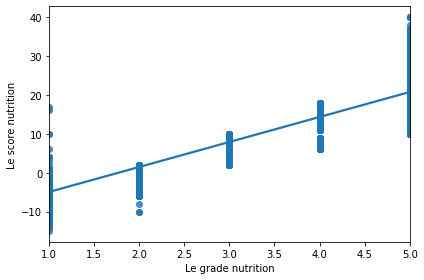

In [33]:
sns.regplot( x="Le grade nutrition", y="Le score nutrition", 
            data=data_both.rename(columns={'nutrition_grade_fr':'Le grade nutrition',
                                       'nutrition-score-fr_100g': 'Le score nutrition'}));
plt.tight_layout()
plt.savefig('regression_score_grade.png')

In [34]:
table = data_both[['nutrition-score-fr_100g', 'nutrition_grade_fr']]
x, y =  data_both['nutrition_grade_fr'], data_both['nutrition-score-fr_100g']

La distance de corrélation indique que les deux variables ne sont pas indépendantes.

In [35]:
scipy.spatial.distance.correlation(x, y)

0.04314357952259906

Le Pearson correlation coefficient, ou PCC, nous indique qu'il y a une relation linéaire entre les deux variables de manière fortement probable.

In [36]:
r, p = scipy.stats.pearsonr(x, y)
r, p

(0.9568564204774009, 0.0)

Avec le calcul de la covariance nous sommes en mesure de constater que les variables varie dans le même sens. C'est le chiffre de $cov(X,Y)$ qui nous indique $Cov(X, Y)\equiv E\left[\left(X - E\left[X\right]\right)\left(Y - E\left[Y\right]\right)\right]\simeq 11.7$, où $E$ désigne l'espérance mathématique. 

In [37]:
np.cov(table.to_numpy(), rowvar=False)

array([[82.00937773, 11.69846922],
       [11.69846922,  1.82264046]])

Si nous calculons le coefficient $\beta$ de la régression linéaire, nous utilisons la bibliothèque scikit-learn, $\beta\simeq 3.4$ :

In [38]:
regressor = LinearRegression(fit_intercept=True)
regressor.fit(x.to_numpy().reshape(-1,1), y.to_numpy().reshape(-1,1))
regressor.coef_, regressor.intercept_

(array([[6.41841849]]), array([-11.34636213]))

### Conclusion de l'analyse bivariée

Nous sommes certains que les variables nutrition-score et nutrition_grade sont corrélées et dépendantes l'une de l'autre. Comme nous voulons simplifier l'information pour les agents sur le terrain, nous utiliserons le plus possible le grade de nutrition pour nos calculs.

## Analyses Univariées non-graphique

In [39]:
data_score = pd.read_csv(NAME_FILE_SCORE_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)
data_grade = pd.read_csv(NAME_FILE_GRADE_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)
data_both = pd.read_csv(NAME_FILE_BOTH_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)

In [40]:
tr.informations(data_score)


dtypes: float64(16), 

memory usage: 54.01 MB


Nombre de lignes: 221210


Nombre de valeurs non-nulles: 3539360


Nombre de valeurs nulles: 0


Nombre de valeurs aberrantes et atypiques: 184739



,columns,type,unique,non-null,mean,std,pct_null,pct>3iqr,max
0,energy_100g,float64,3612,221210,1.18e+03,7.63e+02,0.0,0.10,3900.0
1,fat_100g,float64,16831,221210,1.34e+01,1.61e+01,0.0,1.62,100.0
2,saturated-fat_100g,float64,2146,221210,4.96e+00,7.55e+00,0.0,3.59,92.6
3,trans-fat_100g,float64,72757,221210,6.50e-02,6.58e-01,0.0,10.85,37.0
4,cholesterol_100g,float64,66277,221210,1.92e-02,3.44e-02,0.0,4.94,3.1
5,carbohydrates_100g,float64,20823,221210,3.30e+01,2.80e+01,0.0,0.00,99.8
6,sugars_100g,float64,3932,221210,1.50e+01,1.98e+01,0.0,3.06,99.6
7,fiber_100g,float64,19992,221210,2.66e+00,4.09e+00,0.0,3.42,43.5
8,proteins_100g,float64,2191,221210,7.71e+00,7.71e+00,0.0,2.70,39.0
9,salt_100g,float64,3428,221210,9.51e-01,1.11e+00,0.0,4.21,4.9


In [41]:
tr.thresholding(data_score)

energy_100g
fat_100g
saturated-fat_100g
trans-fat_100g
cholesterol_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
vitamin-a_100g
vitamin-c_100g
calcium_100g
iron_100g
nutrition-score-fr_100g

dtypes: float64(16), 

memory usage: 54.01 MB


Nombre de lignes: 221210


Nombre de valeurs non-nulles: 3539360


Nombre de valeurs nulles: 0


Nombre de valeurs au-dessus du seuil: 35706



,columns,non-nulls,limits,max,min,outliers,negatives,kurtosis,skewness,mode,median
0,energy_100g,221210,3.9e+03,3900.0,0.0,0,0,-0.59,0.32,2092.0,1.19e+03
1,fat_100g,221210,1e+02,100.0,0.0,0,0,4.46,1.82,0.0,7.14e+00
2,saturated-fat_100g,221210,93,92.6,0.0,0,0,19.23,3.21,0.0,1.79e+00
3,trans-fat_100g,221210,37,37.0,0.0,0,0,1453.36,32.98,0.0,0.00e+00
4,cholesterol_100g,221210,3.1,3.1,0.0,0,0,1529.14,20.15,0.0,5.72e-03
5,carbohydrates_100g,221210,1e+02,99.8,0.0,0,0,-1.13,0.48,0.0,2.40e+01
6,sugars_100g,221210,1e+02,99.6,0.0,0,0,2.26,1.66,0.0,5.00e+00
7,fiber_100g,221210,44,43.5,0.0,0,0,25.11,3.96,0.0,1.50e+00
8,proteins_100g,221210,39,39.0,0.0,0,0,2.04,1.44,0.0,5.70e+00
9,salt_100g,221210,4.9,4.9,0.0,0,0,3.37,1.80,0.0,6.45e-01


## Calcul du nombre d'échantillon par note

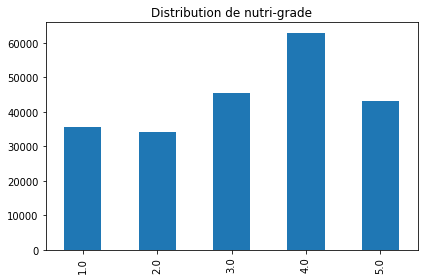

In [42]:
%matplotlib inline
data_grade['nutrition_grade_fr'].value_counts().sort_index().plot(kind='bar', title='Distribution de nutri-grade')
plt.tight_layout()
plt.savefig('distribution_nutrigrade.png')

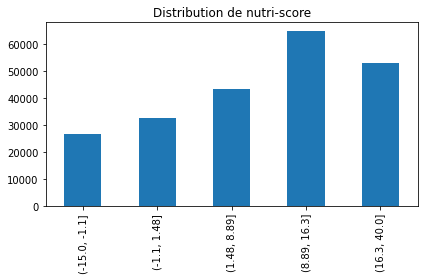

In [43]:
pd.cut(data_score['nutrition-score-fr_100g'], [-15, -1.1, 1.48, 8.89, 16.3, 40]).value_counts().sort_index().plot(kind='bar', title='Distribution de nutri-score')
plt.tight_layout()
plt.savefig('distribution_nutriscore.png')

## Calcul de la moyenne des additifs dans la base de données

### En barchart, en quantité

<AxesSubplot:title={'center':"Nombre d'additifs par nutri-score\nen moyenne."}, xlabel='Nutri-score', ylabel="Nombre d'additifs en moyenne">

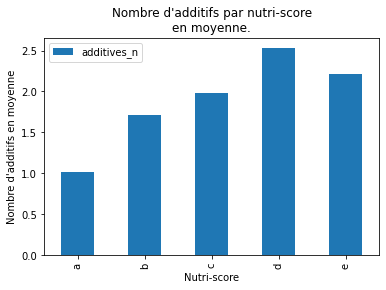

In [44]:
df.loc[~df['nutrition_grade_fr'].isnull(), ['additives_n', 'nutrition_grade_fr']].groupby(by=['nutrition_grade_fr']).mean().plot(kind='bar', ylabel='Nombre d\'additifs en moyenne', xlabel='Nutri-score', title='Nombre d\'additifs par nutri-score\nen moyenne.')#.value_counts().sort_index()#.plot(kind='bar')

### En piechart, en pourcentage par rapport au total des additifs dans la base

In [45]:
pie = dict()
for note in df.loc[~df['nutrition_grade_fr'].isnull(), 'nutrition_grade_fr'].unique():
    pie.update({note: df['sugars_100g'].loc[(df['nutrition_grade_fr']==note)].mean()})

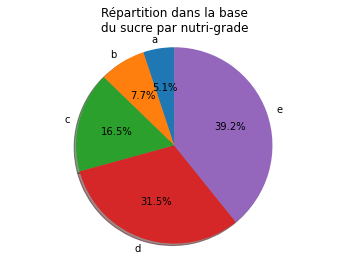

In [46]:
dataframe = pd.DataFrame(pie, columns=['a', 'b', 'c', 'd', 'e'], index=range(1))
a = dataframe
labels = ['a', 'b', 'c', 'd', 'e']
sizes = a.values.reshape(5,)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title('Répartition dans la base\ndu sucre par nutri-grade')
plt.show()
fig1.savefig('pie_chart_sugars_ratio.png')

### En piechart, en pourcentage par rapport au total des produits issues d'huile de palme dans la base

In [47]:
pie = dict()
for note in df.loc[~df['nutrition_grade_fr'].isnull(), 'nutrition_grade_fr'].unique():
    pie.update({note: df['ingredients_from_palm_oil_n'].loc[(df['nutrition_grade_fr']==note)].sum()})

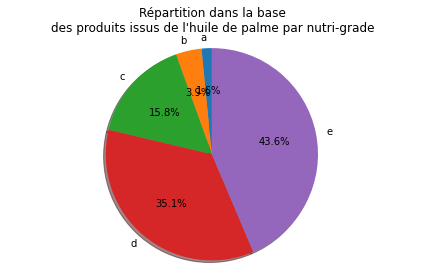

In [48]:
dataframe = pd.DataFrame(pie, columns=['a', 'b', 'c', 'd', 'e'], index=range(1))
a = dataframe
labels = ['a', 'b', 'c', 'd', 'e']
sizes = a.values.reshape(5,)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title('Répartition dans la base\ndes produits issus de l\'huile de palme par nutri-grade')
plt.tight_layout()
plt.show()
fig1.savefig('pie_chart_palm_oil_n.png')

### La proportion de graisse saturée selon le nutri-score

In [49]:
import seaborn as sns

In [50]:
#data_score = pd.read_csv(NAME_FILE_SCORE_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)
#data_grade = pd.read_csv(NAME_FILE_GRADE_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)
#data_both = pd.read_csv(NAME_FILE_BOTH_UNIVARIATE_ANALYSIS, sep='\t', index_col=0)

## Création des graphiques d'intéractions entre deux variables

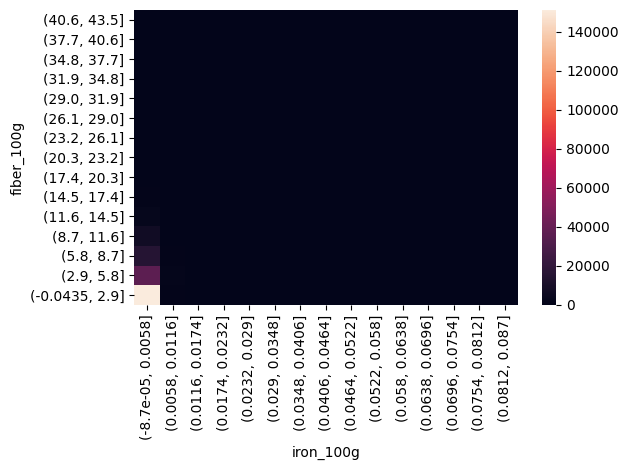

In [51]:
%matplotlib inline
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
liste = [['carbohydrates_100g', 'sugars_100g'], ['salt_100g', 'sodium_100g'], 
         ['nutrition-score-fr_100g', 'fat_100g'], ['nutrition-score-fr_100g', 'saturated-fat_100g'],
        ['nutrition-score-fr_100g', 'trans-fat_100g'], ['nutrition-score-fr_100g', 'energy_100g'],
         ['energy_100g', 'fat_100g'], ['energy_100g', 'saturated-fat_100g'], ['proteins_100g', 'calcium_100g'],
        ['iron_100g', 'fiber_100g']]
for name in liste:
    tr.heatmaps(name[0], name[1], 500)
    tr.interactions(name[0], name[1], 15)

## Création des graphiques de densité par note moyenne et quantité de valeurs.

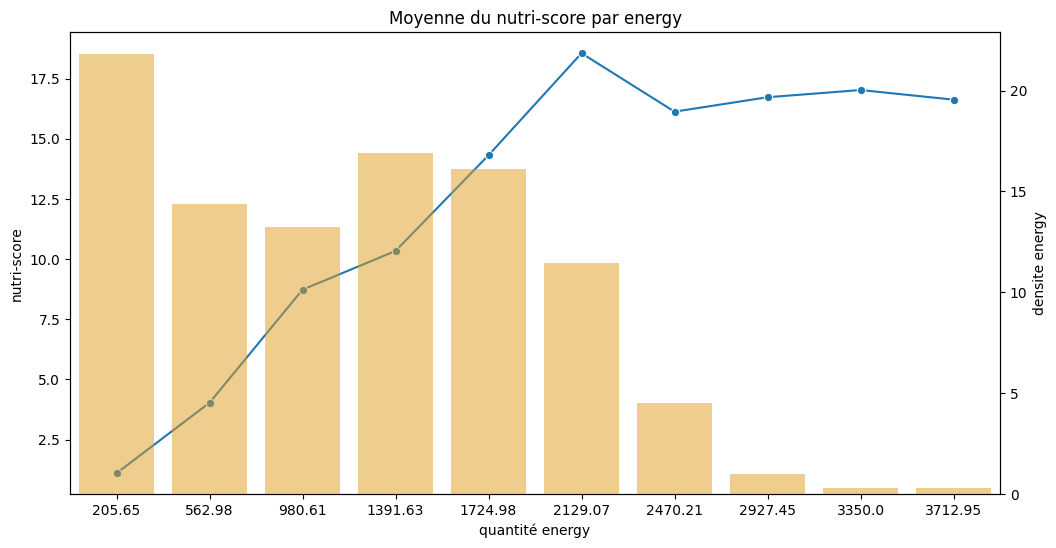

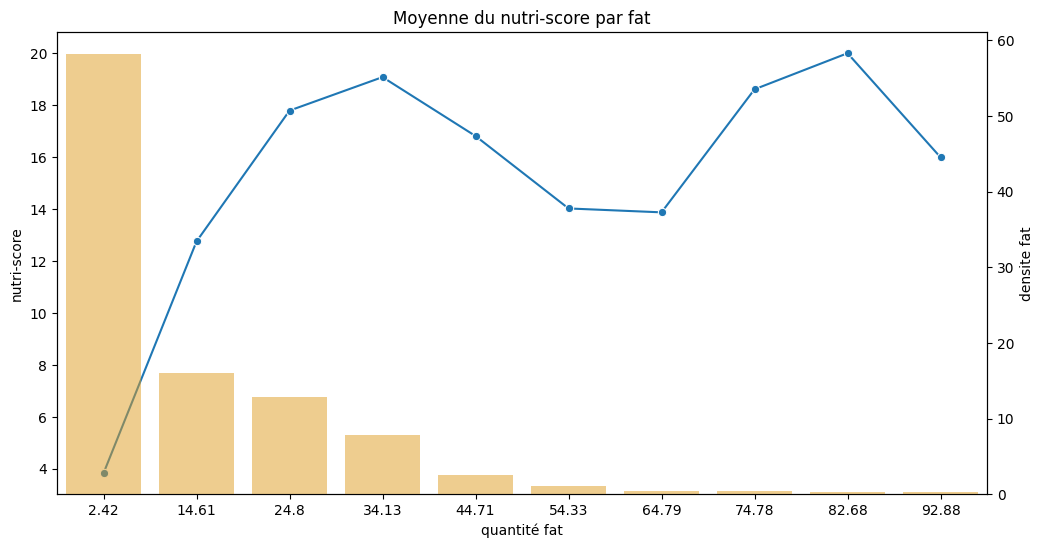

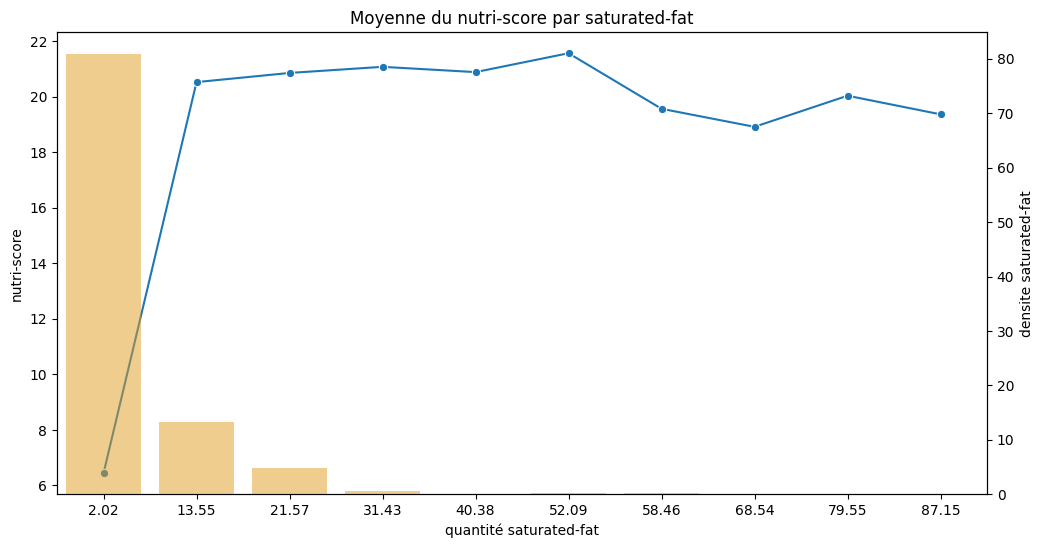

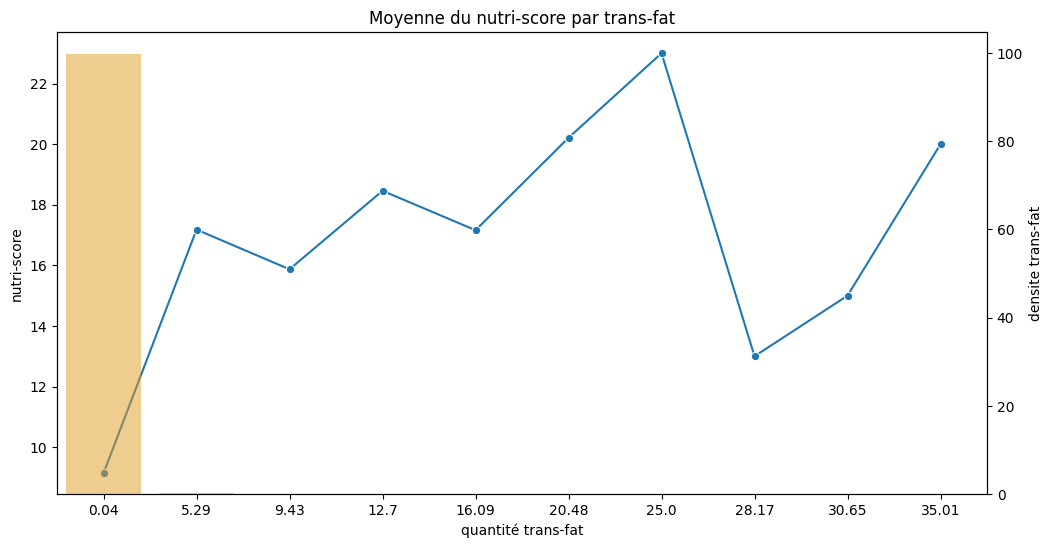

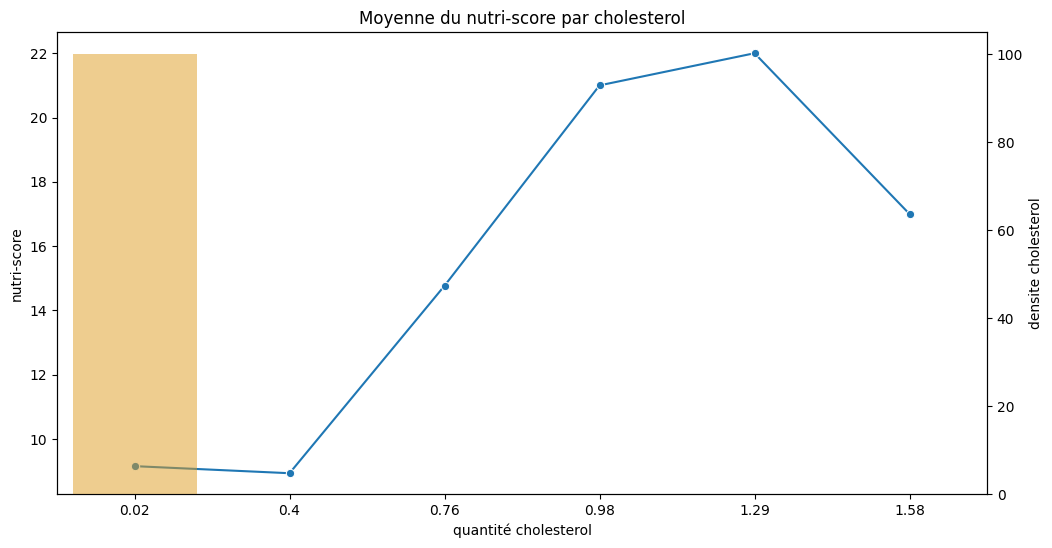

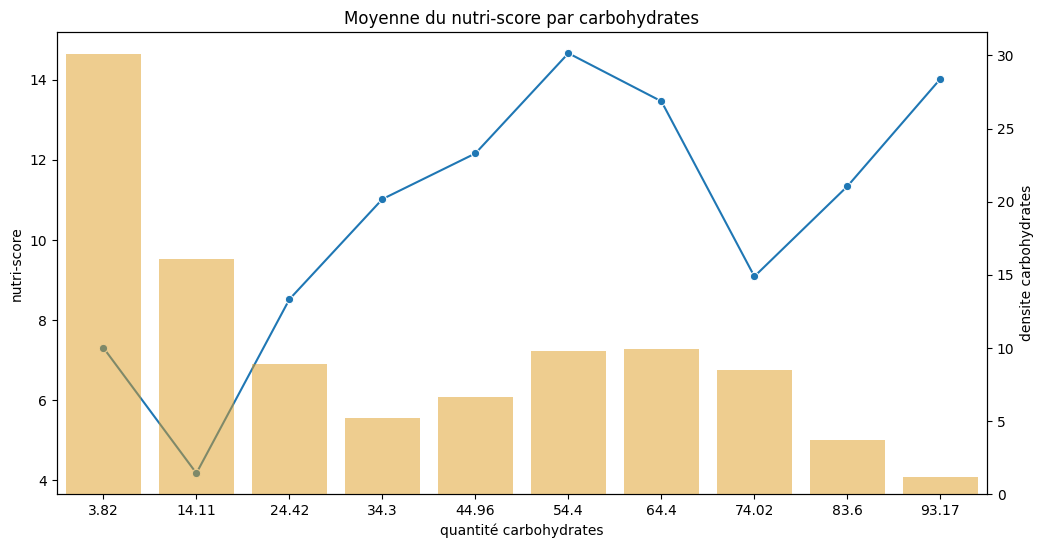

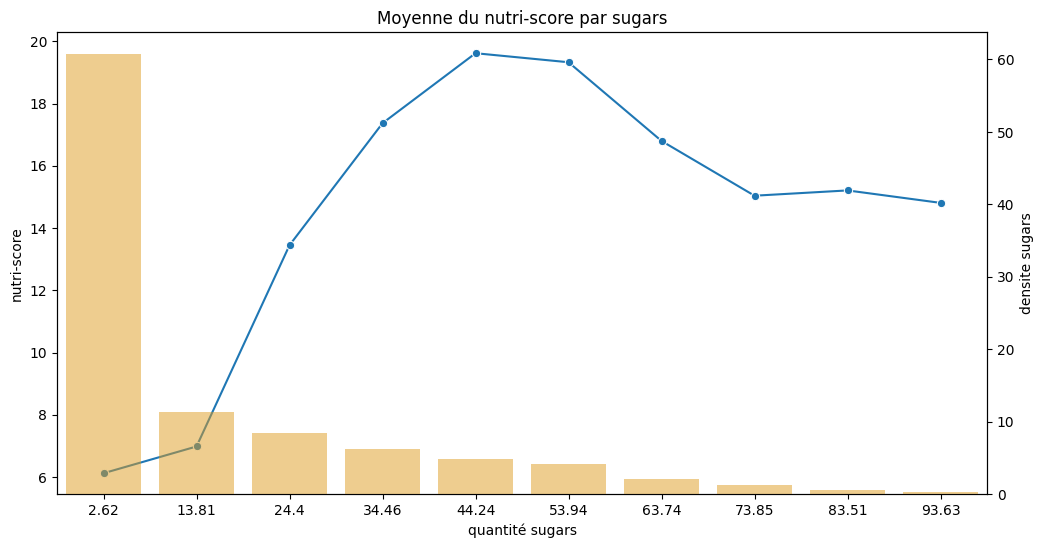

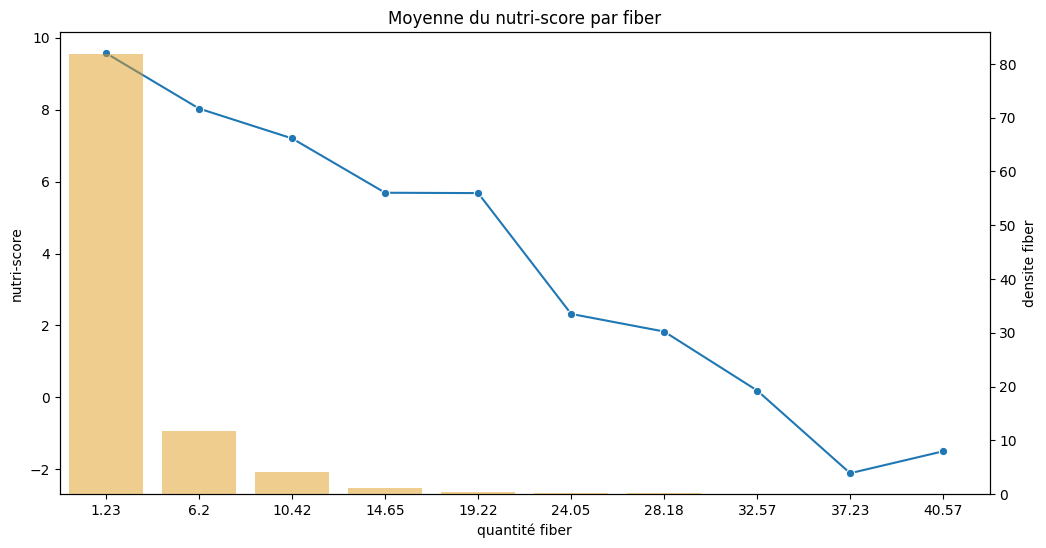

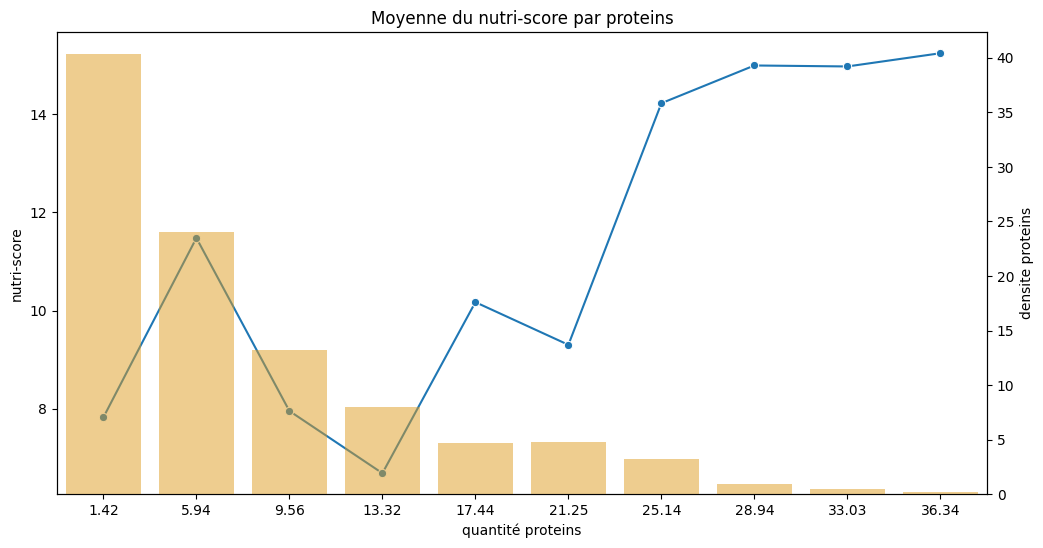

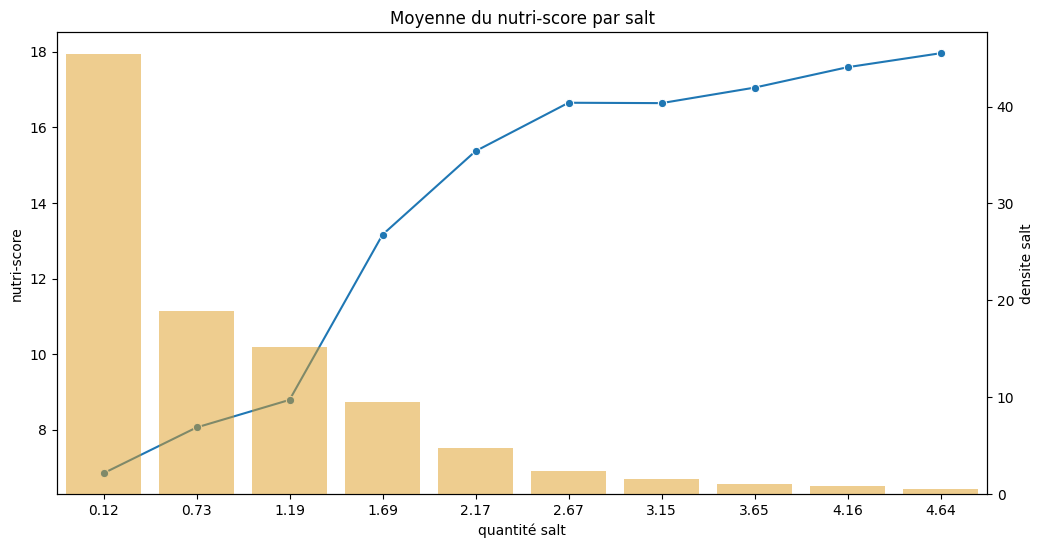

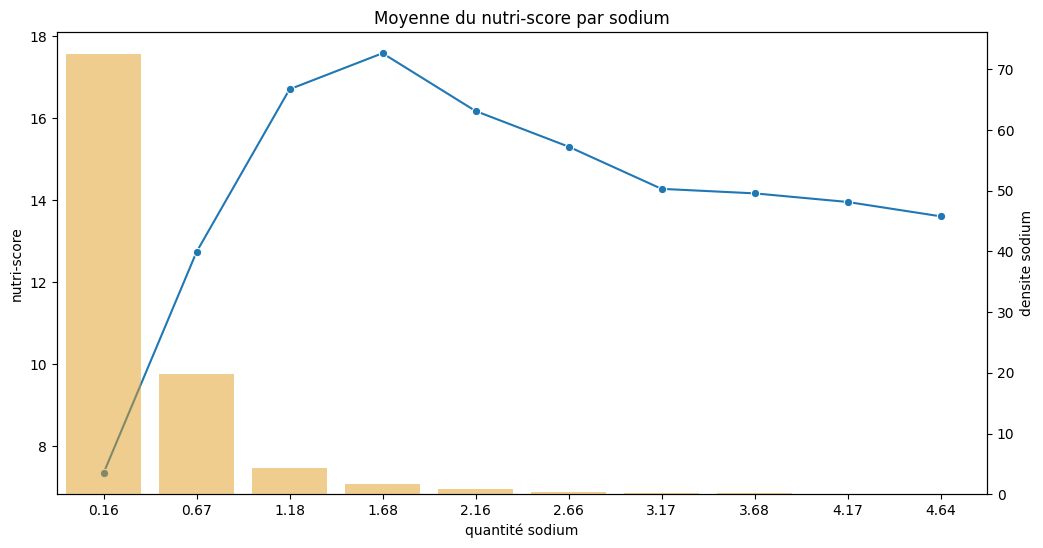

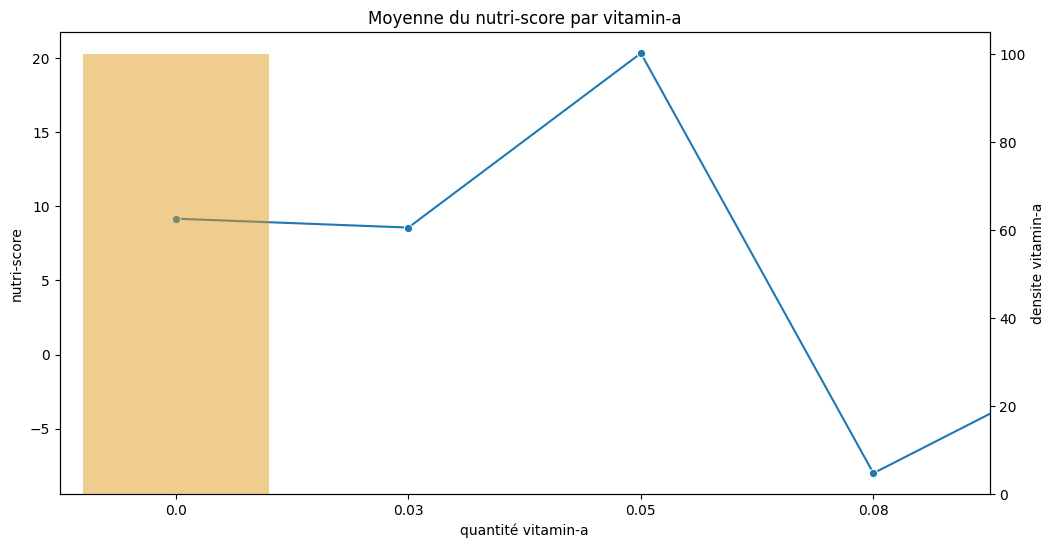

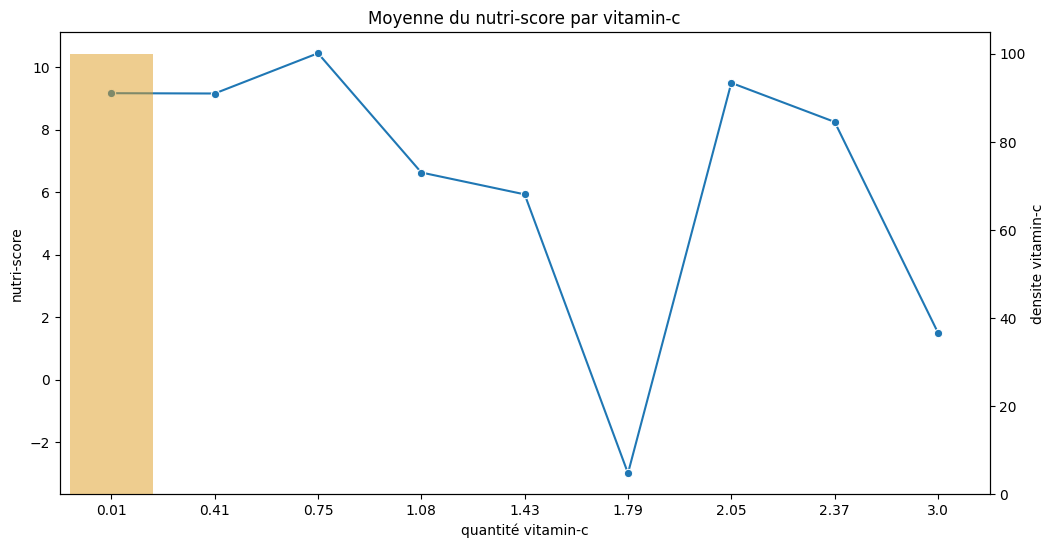

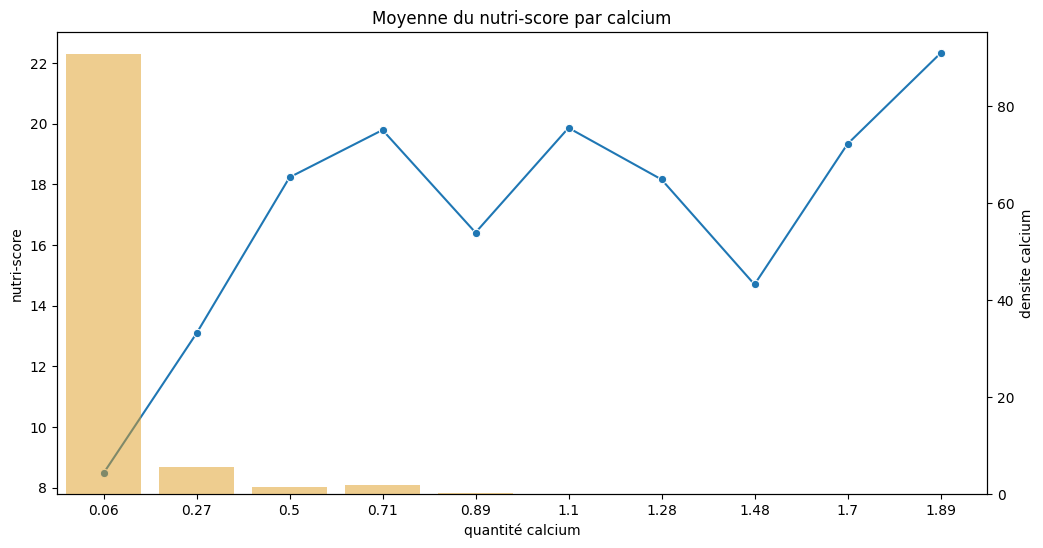

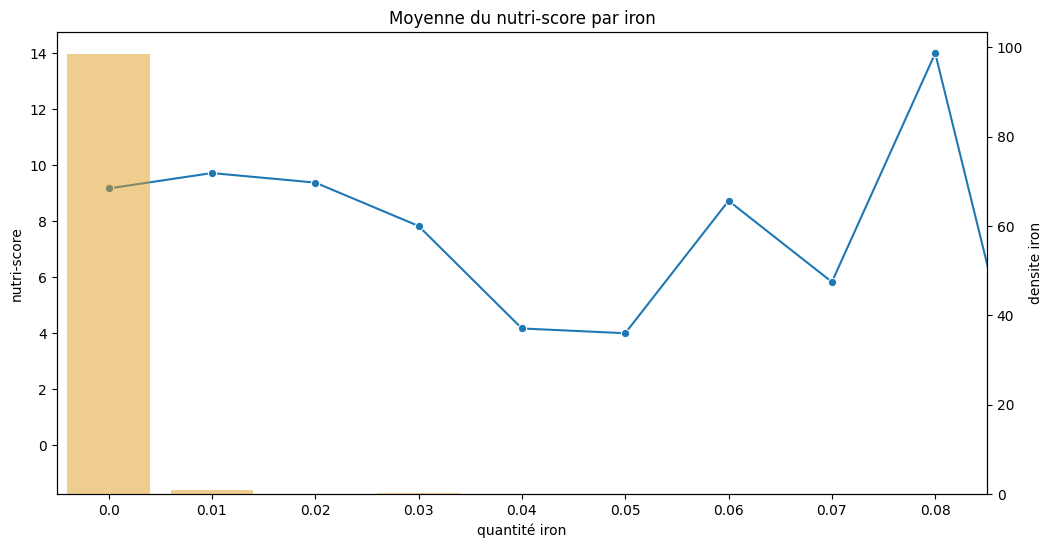

In [52]:
tr.barline_plot(10) # Un exemple parmi tous les graphiques créés est ci-dessous

![]('nutriscore_par_fat_100g.png')

## Création de la matrice de corrélations

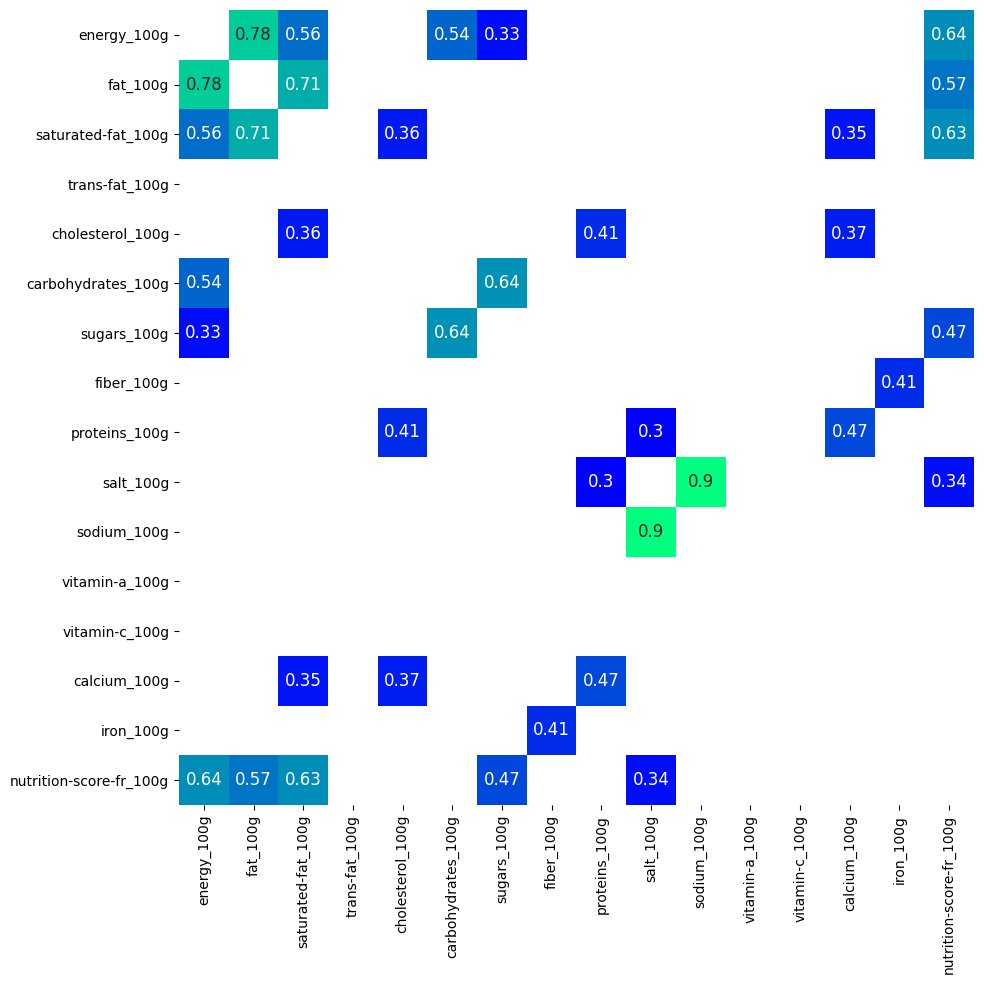

In [53]:
%matplotlib inline
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig, ax = plt.subplots(figsize=(10,10))
sns.set_theme(font_scale=1, palette='deep')



matcorr = data_score.corr()
mask = np.zeros_like(matcorr)

#mask[np.triu_indices_from(mask)] = False
mask = np.where((matcorr>0.3)&(matcorr!=1), False, True)
sns.heatmap(matcorr, annot=True,square=True, mask=mask, cmap='winter', cbar=False)
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 100
plt.tight_layout()
plt.savefig('correlations_matrix.png')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Les catégories de groupes d'aliments en détail court

In [54]:
data_cat = data_both.copy()

In [55]:
#data_cat['pnns_groups_1'] = df['pnns_groups_1']
#data_cat.to_excel('data_cat_1.xlsx')
data_cat = pd.read_excel('data_cat_1.xlsx')

In [56]:
data_cat = data_cat[~data_cat['pnns_groups_1'].isnull()]

In [57]:
data_cat = data_cat[data_cat['pnns_groups_1'] != 'unknown']

In [58]:
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('salty-snacks', 'Salty snacks')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('sugary-snacks', 'Sugary snacks')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('cereals-and-potatoes', 'Cereals and potatoes')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('fruits-and-vegetables', 'Fruits and vegetables')

In [59]:
data_cat['nutri_grade_cut_cat'] = pd.cut(data_cat['nutrition_grade_fr'],
       5, labels=["a", "b", "c", "d", "e"])

In [60]:
translate = {'Fruits and vegetables': 'Fruits et légumes',
 'Sugary snacks': 'Snacks sucrés',
 'Composite foods': 'Nourritures composées',
 'Beverages': 'Boissons',
 'Fish Meat Eggs': 'Œufs Viandes Poissons',
 'Fat and sauces': 'Graisses et sauces',
 'Cereals and potatoes': 'Céréales et pommes de terre',
 'Milk and dairy products': 'Laits et produits laitiers',
 'Salty snacks': 'Snacks salés'}

In [61]:
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].map(translate)

In [62]:
data_cat = data_cat.sort_values(by='pnns_groups_1', axis=0)

### Boxplot des distributions par catégories

In [63]:
data_cat_mean = data_cat.groupby(by=['pnns_groups_1']).mean()
data_cat_mean = data_cat_mean.reset_index()

In [64]:
data_cat_mean = data_cat_mean.sort_values(by=['nutrition-score-fr_100g'])

### Barplot des moyennes par catégories

In [65]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
sns.set_theme(style="whitegrid")
plt.rcParams["ytick.labelsize"] = "10"
ax = sns.barplot(x="nutrition-score-fr_100g", y="pnns_groups_1", data=data_cat_mean).set(title='Nutri-score moyen\npar groupe')
plt.tight_layout()
plt.savefig('categorie_means_1.png')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()

## Les catégories de groupes d'aliments en détail long

In [66]:
data_cat = data_both.copy()

In [67]:
data_cat['pnns_groups_2'] = df['pnns_groups_2']
#data_cat.to_excel('data_cat_2.xlsx')
#data_cat = pd.read_excel('data_cat_2.xlsx')

In [68]:
data_cat = data_cat[~data_cat['pnns_groups_2'].isnull()]

In [69]:
data_cat = data_cat[data_cat['pnns_groups_2'] != 'unknown']

In [70]:
data_cat['nutri_grade_cut_cat'] = pd.cut(data_cat['nutrition_grade_fr'],
       5, labels=["a", "b", "c", "d", "e"])

In [71]:
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('legumes', 'Legumes')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('fruits', 'Fruits')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('vegetables', 'Vegetables')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('cereals', 'Cereals')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('nuts', 'Nuts')

In [72]:
translate = {'Vegetables': 'Légumes',
 'Biscuits and cakes': 'Biscuits et gâteaux',
 'Pizza pies and quiche': 'Pizzas et quiches',
 'Sweets': 'Bonbons',
 'Sweetened beverages': 'Boissons sucrées',
 'One-dish meals': 'Plats cuisinées',
 'Soups': 'Soupes',
 'Meat': 'Viandes',
 'Dressings and sauces': 'Vinaigrettes et sauces',
 'Cereals': 'Céréales',
 'Fruits': 'Fruits',
 'Milk and yogurt': 'Lait et yaourt',
 'Fats': 'Graisses',
 'Non-sugared beverages': 'Boissons non-sucrées',
 'Cheese': 'Fromages',
 'Chocolate products': 'Produits chocolatés',
 'Sandwich': 'Sandwichs',
 'Bread': 'Pains',
 'Nuts': 'Noisettes',
 'Legumes': 'Légumineuses',
 'Breakfast cereals': 'Céréales petits-déj.',
 'Appetizers': 'Biscuits apéritifs',
 'Fruit juices': 'Jus de fruits',
 'Eggs': 'Œufs',
 'Fish and seafood': 'Poissons et produits de la mer',
 'Dried fruits': 'Fruits secs',
 'Ice cream': 'Crèmes glacées',
 'Processed meat': 'Viandes transformées',
 'pastries': 'Pâtes',
 'Dairy desserts': 'Produits laitiers',
 'Alcoholic beverages': 'Alcool',
 'Potatoes': 'Pommes de terre',
 'Artificially sweetened beverages': 'Boissons édulcorées artificiellement',
 'Fruit nectars': 'Nectars de fruits',
 'Salty and fatty products': 'Produits gras et salés',
 'Tripe dishes': 'Abats'}

In [73]:
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].map(translate)

In [74]:
data_cat = data_cat.sort_values(by='pnns_groups_2', axis=0)

### Boxplot des distributions par catégories

In [75]:
sns.set(rc={"figure.figsize":(32, 18)})
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Nutri-score", y="Catégories",hue='nutrition\ngrade', whis = 3,
            data=data_cat[['nutrition-score-fr_100g', 'pnns_groups_2', 'nutri_grade_cut_cat']]
                    .rename(columns={'nutrition-score-fr_100g':'Nutri-score',
                                       'pnns_groups_2': 'Catégories', 'nutri_grade_cut_cat': 'nutrition\ngrade'}))
plt.savefig('categories_distributions_2.png')
plt.close()

In [76]:
data_cat_mean = data_cat.groupby(by=['pnns_groups_2']).mean()
data_cat_mean = data_cat_mean.reset_index()

In [77]:
data_cat_mean = data_cat_mean.sort_values(by=['nutrition-score-fr_100g'])

### Barplot des moyennes par catégories

In [78]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
sns.set(rc={"figure.figsize":(32, 18)})
sns.set_theme(style="whitegrid")
plt.rcParams["axes.titlesize"] = '40'
plt.rcParams["ytick.labelsize"] = "20"
ax = sns.barplot(x="nutrition-score-fr_100g", y="pnns_groups_2", data=data_cat_mean).set(title='Nutri-score moyen\npar groupe')
plt.tight_layout()
plt.savefig('categorie_means_2.png')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()

## Les catégories de groupes détaillées en long

In [79]:
data_cat = data_both.copy()

In [80]:
data_cat['pnns_groups_2'] = df['pnns_groups_2']
data_cat.to_excel('data_cat_2.xlsx')
data_cat = pd.read_excel('data_cat_2.xlsx')

In [81]:
data_cat = data_cat[~data_cat['pnns_groups_2'].isnull()]

In [82]:
data_cat = data_cat[data_cat['pnns_groups_2'] != 'unknown']

In [83]:
data_cat['nutri_grade_cut_cat'] = pd.cut(data_cat['nutrition_grade_fr'],
       5, labels=["a", "b", "c", "d", "e"])

In [84]:
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('legumes', 'Legumes')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('fruits', 'Fruits')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('vegetables', 'Vegetables')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('cereals', 'Cereals')
data_cat['pnns_groups_2'] = data_cat['pnns_groups_2'].replace('nuts', 'Nuts')

In [85]:
# Prends 15 minutes de temps de calculs:
#results = {}
#for cat in data_cat['pnns_groups_2']:
#    liste_de_note = []
#    for note in range(5):        
#        value = data_cat.loc[(data_cat['nutrition_grade_fr'] ==  note + 1)
#                             & (data_cat['pnns_groups_2'] == cat)].shape[0] if\
#        (data_cat.loc[(data_cat['nutrition_grade_fr'] ==  1)
#                             & (data_cat['pnns_groups_2'] == cat)].shape[0] is not None) else 0
#        liste_de_note.append(value)
#    results.update({
#            cat: liste_de_note})
#tr.write_to_pickle('categories.dat', results)
results = pd.read_pickle('categories_2.dat')

In [86]:
translate = {'Vegetables': 'Légumes',
 'Biscuits and cakes': 'Biscuits et gâteaux',
 'Pizza pies and quiche': 'Pizzas et quiches',
 'Sweets': 'Bonbons',
 'Sweetened beverages': 'Boissons sucrées',
 'One-dish meals': 'Plats cuisinées',
 'Soups': 'Soupes',
 'Meat': 'Viandes',
 'Dressings and sauces': 'Vinaigrettes et sauces',
 'Cereals': 'Céréales',
 'Fruits': 'Fruits',
 'Milk and yogurt': 'Lait et yaourt',
 'Fats': 'Graisses',
 'Non-sugared beverages': 'Boissons non-sucrées',
 'Cheese': 'Fromages',
 'Chocolate products': 'Produits chocolatés',
 'Sandwich': 'Sandwichs',
 'Bread': 'Pains',
 'Nuts': 'Noisettes',
 'Legumes': 'Légumineuses',
 'Breakfast cereals': 'Céréales petits-déj.',
 'Appetizers': 'Biscuits apéritifs',
 'Fruit juices': 'Jus de fruits',
 'Eggs': 'Œufs',
 'Fish and seafood': 'Poissons et produits de la mer',
 'Dried fruits': 'Fruits secs',
 'Ice cream': 'Crèmes glacées',
 'Processed meat': 'Viandes transformées',
 'pastries': 'Pâtes',
 'Dairy desserts': 'Produits laitiers',
 'Alcoholic beverages': 'Alcool',
 'Potatoes': 'Pommes de terre',
 'Artificially sweetened beverages': 'Boissons édulcorées artificiellement',
 'Fruit nectars': 'Nectars de fruits',
 'Salty and fatty products': 'Produits gras et salés',
 'Tripe dishes': 'Abats'}

In [87]:
french_results = {}
for key, value in results.items():
    french_results.update({translate[key]: value})
results = french_results

In [88]:
temp = pd.DataFrame(results).T
temp.index.name = 'pnns_groups_2'
temp = temp.sort_values(by='pnns_groups_2', axis=0)
#results = temp.T.to_dict()

In [89]:
liste = []
dictio = temp.T.to_dict()
for key_i, value_i in dictio.items():
    for key_j, value_j in dictio[key_i].items():
        liste.append(temp.T.to_dict()[key_i][key_j])
    dictio[key_i] = liste
    liste = []
results = dictio

### Barplot bivarié

<ipython-input-90-465a5a04127f>:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('categories_2.png', bbox='tight')


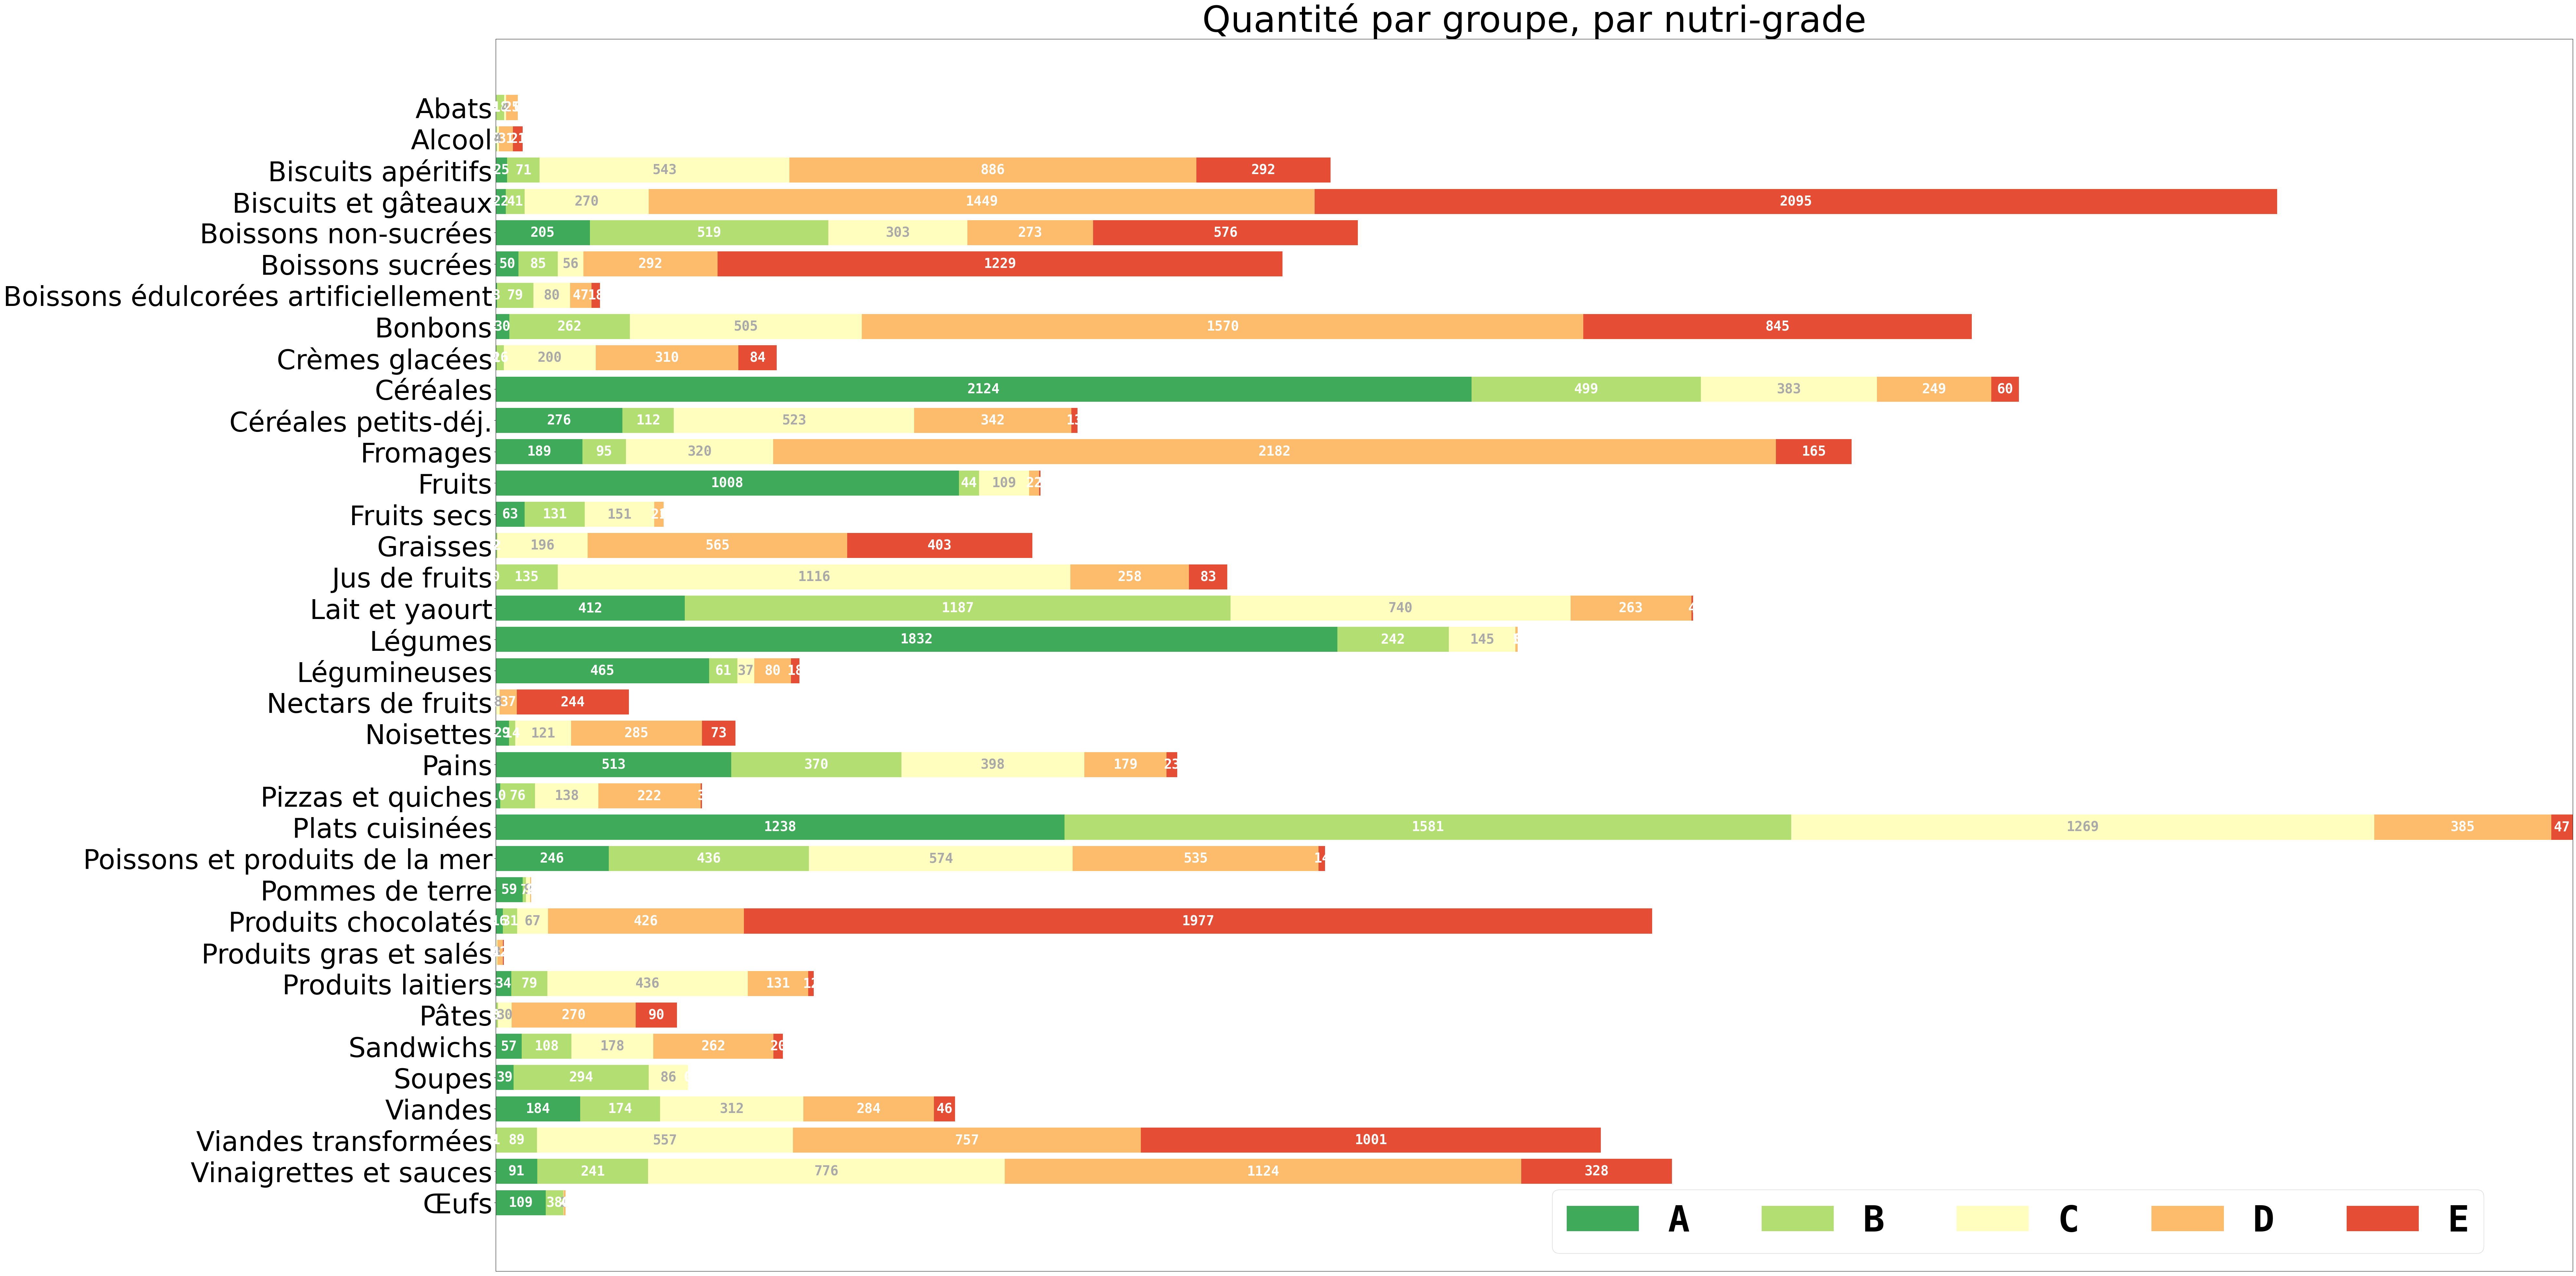

In [90]:
category_names = ['A', 'B',
                  'C', 'D', 'E']

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    #plt.rcParams["font.family"] = "Times New Roman"
    #plt.rcParams["font.size"] = "40"
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["ytick.labelsize"] = "60"
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(80, 40))
    plt.tight_layout()
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    fontsize = 12
    font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : '30'}
    plt.rc('font', **font)
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        
        rects = ax.barh(labels, widths, left=starts, height=0.8,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0.5, 0),
              loc='lower left', fontsize=80)
    ax.set_title('Quantité par groupe, par nutri-grade', fontsize='80')
    plt.tight_layout()
    fig.savefig('categories_2.png', bbox='tight')
    return fig, ax


survey(results, category_names)
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


### Les catégories de groupes détaillées en court

In [91]:
data_cat = data_both.copy()

In [92]:
#data_cat['pnns_groups_1'] = df['pnns_groups_1']
#data_cat.to_excel('data_cat_1.xlsx')
data_cat = pd.read_excel('data_cat_1.xlsx')

In [93]:
data_cat = data_cat[~data_cat['pnns_groups_1'].isnull()]

In [94]:
data_cat = data_cat[data_cat['pnns_groups_1'] != 'unknown']

In [95]:
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('salty-snacks', 'Salty snacks')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('sugary-snacks', 'Sugary snacks')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('cereals-and-potatoes', 'Cereals and potatoes')
data_cat['pnns_groups_1'] = data_cat['pnns_groups_1'].replace('fruits-and-vegetables', 'Fruits and vegetables')

In [96]:
data_cat['nutri_grade_cut_cat'] = pd.cut(data_cat['nutrition_grade_fr'],
       5, labels=["a", "b", "c", "d", "e"])

In [97]:
# Prends 15 minutes de temps de calculs:
#results = {}
#for cat in data_cat['pnns_groups_1']:
#    liste_de_note = []
#    for note in range(5):        
#        value = data_cat.loc[(data_cat['nutrition_grade_fr'] ==  note + 1)
#                             & (data_cat['pnns_groups_1'] == cat)].shape[0] if\
#        (data_cat.loc[(data_cat['nutrition_grade_fr'] ==  1)
#                             & (data_cat['pnns_groups_1'] == cat)].shape[0] is not None) else 0
#        liste_de_note.append(value)
#    results.update({
#            cat: liste_de_note})
#tr.write_to_pickle('categories_1.dat', results)
results = pd.read_pickle('categories_1.dat')

In [98]:
translate = {'Fruits and vegetables': 'Fruits et légumes',
 'Sugary snacks': 'Snacks sucrés',
 'Composite foods': 'Nourritures composées',
 'Beverages': 'Boissons',
 'Fish Meat Eggs': 'Œufs Viandes Poissons',
 'Fat and sauces': 'Graisses et sauces',
 'Cereals and potatoes': 'Céréales et pommes de terre',
 'Milk and dairy products': 'Laits et produits laitiers',
 'Salty snacks': 'Snacks salés'}

In [99]:
french_results = {}
for key, value in results.items():
    french_results.update({translate[key]: value})
results = french_results

In [100]:
temp = pd.DataFrame(results).T
temp.index.name = 'pnns_groups_1'
temp = temp.sort_values(by='pnns_groups_1', axis=0)
#results = temp.T.to_dict()

In [101]:
liste = []
dictio = temp.T.to_dict()
for key_i, value_i in dictio.items():
    for key_j, value_j in dictio[key_i].items():
        liste.append(temp.T.to_dict()[key_i][key_j])
    dictio[key_i] = liste
    liste = []
results = dictio

### Barplot Bivarié

<ipython-input-102-85f42e8a8a2b>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('categories_1.png', bbox='tight')


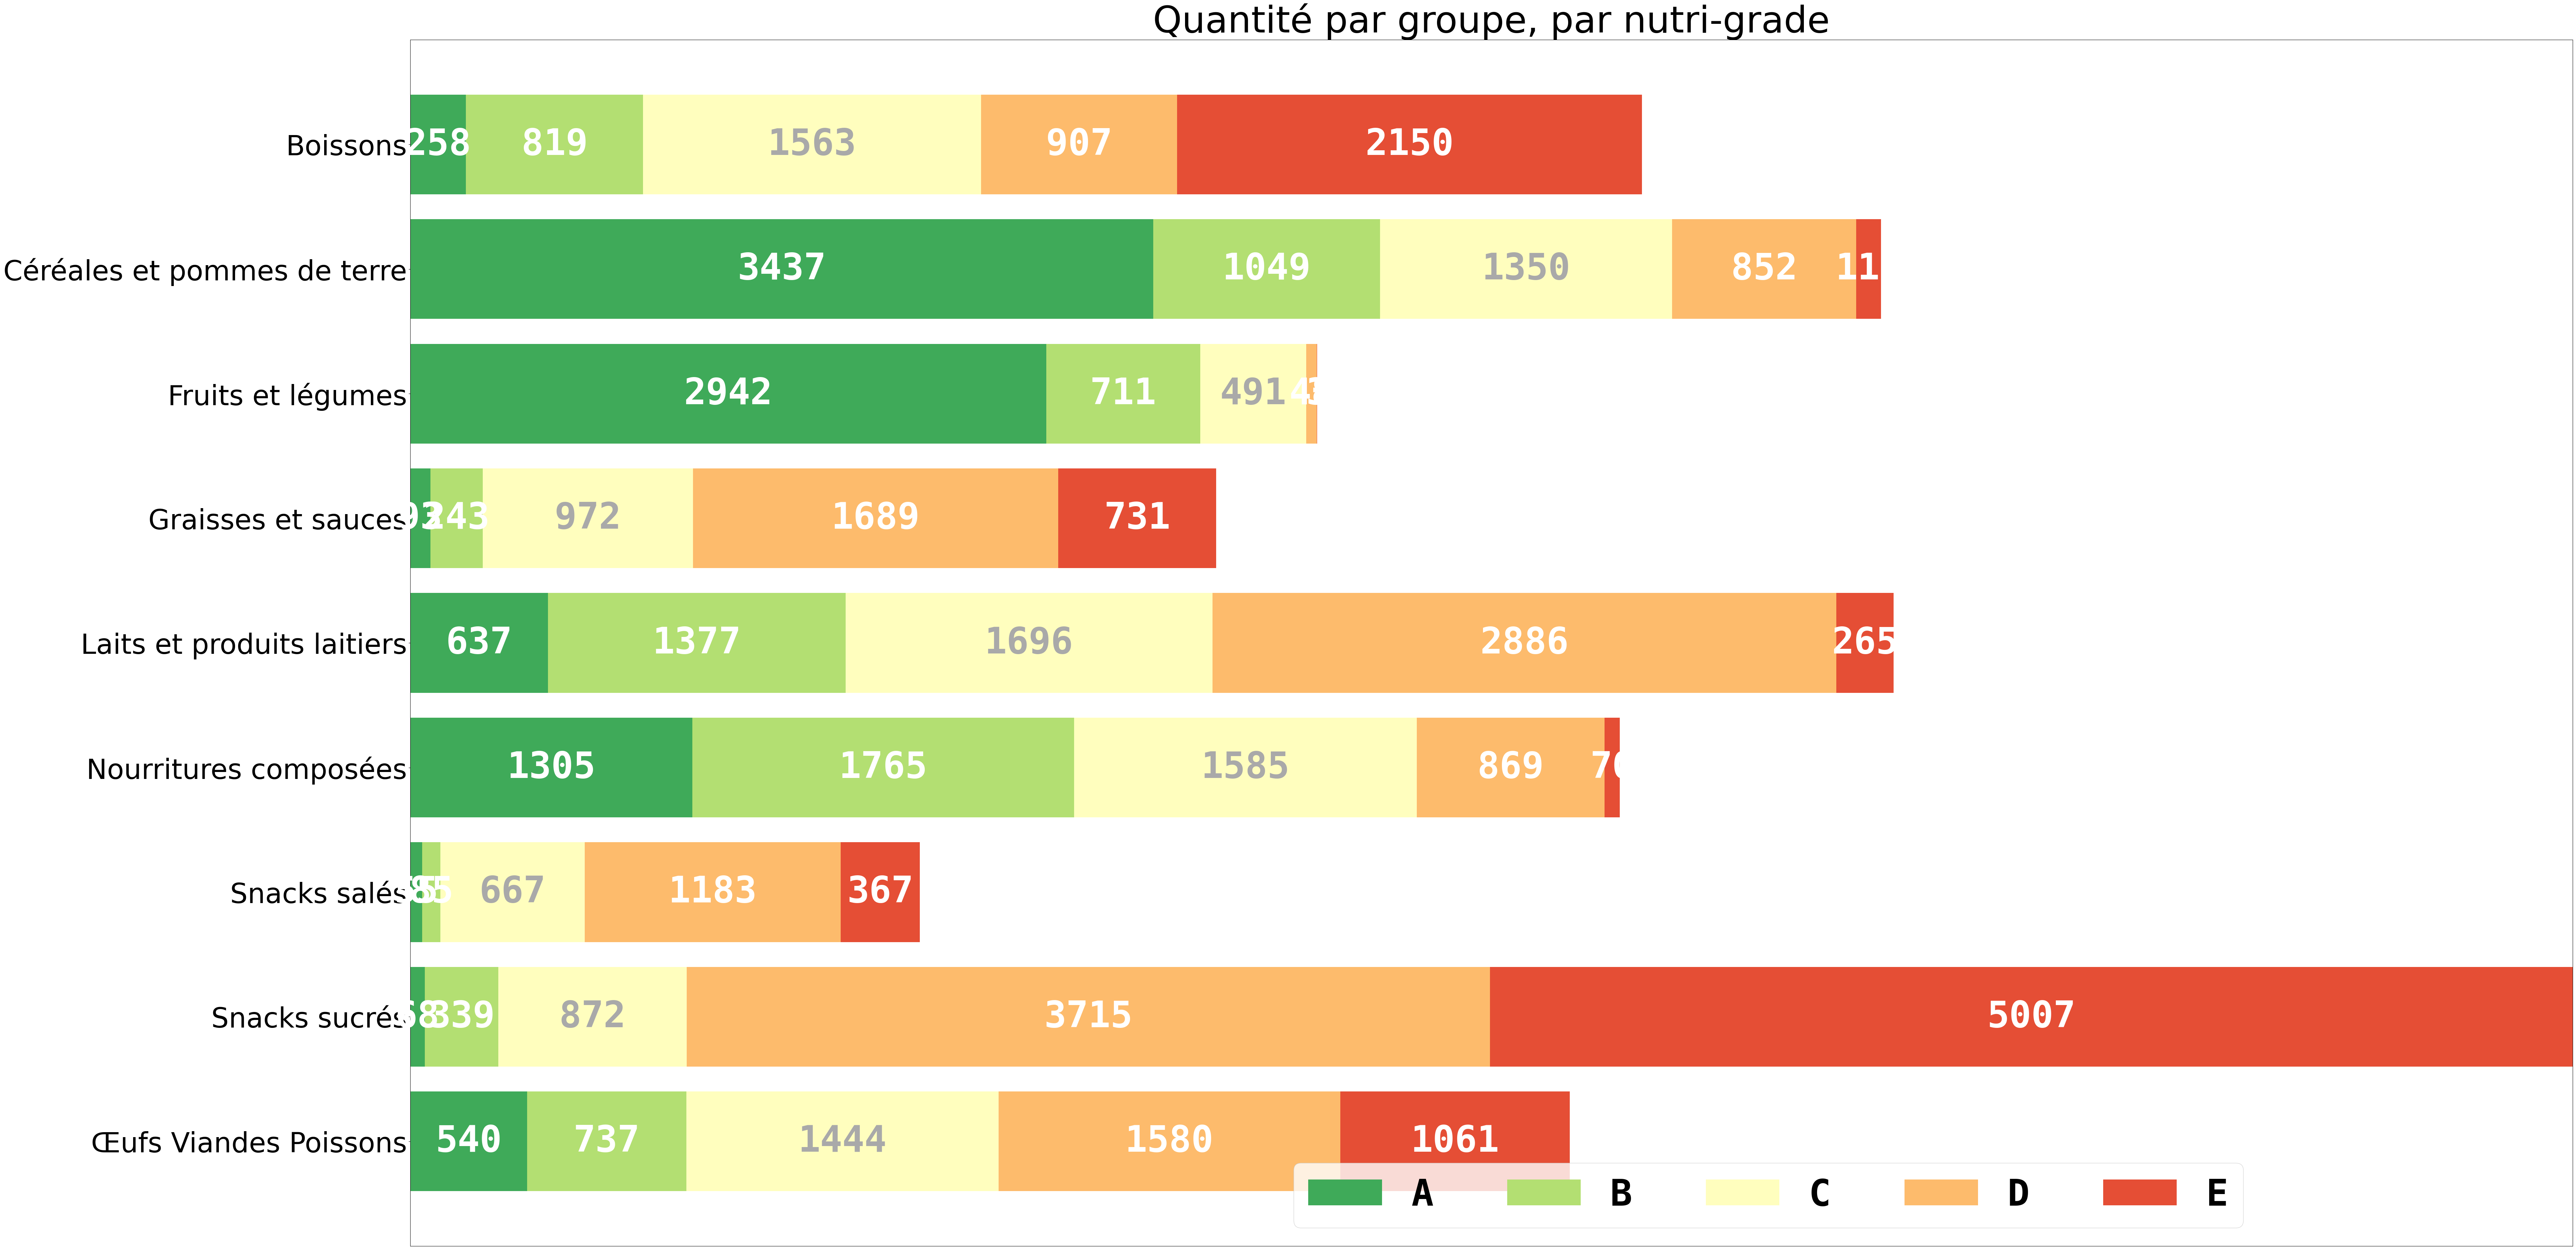

In [102]:
category_names = ['A', 'B',
                  'C', 'D', 'E']

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["ytick.labelsize"] = "60"
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(80, 40))
    plt.tight_layout()
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    fontsize = 12
    font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : '80'}
    plt.rc('font', **font)
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        
        rects = ax.barh(labels, widths, left=starts, height=0.8,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0.4, 0),
              loc='lower left', fontsize=80)
    ax.set_title('Quantité par groupe, par nutri-grade', fontsize='80')
    plt.tight_layout()
    fig.savefig('categories_1.png', bbox='tight')
    return fig, ax


survey(results, category_names)
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
